In [1]:
from sys import path
path.append("../")
%matplotlib inline  
import matplotlib.pyplot as plt

# Coastal Boundary Classifier algorithm
This coastal boundary algorithm is used to classify a given pixel as either coastline or not coastline using a simple binary format like in the table before.  

<br>

$\begin{array}{|c|c|}
\hline
1& Coastline  \\ \hline
0& Not Coastline \\ \hline
\end{array}$

<br>  


The algorithm makes a classification by examining surrounding pixels and making a determination based on how many pixels around it are water  

<br>  

![img](diagrams/coastline_classification/b1.png)   
  
<br>

If the count of land pixels surrounding a pixel exceeds 5, then it's likely not coastline.
If the count of land pixels surrounding a pixel does not exceed 1, then it's likely not a coastline
  
<br>

$$
Classification(pixel) = \begin{cases} 
      1 & 2\le  count\_water\_surrounding(pixel)  \leq  5 \\
      0 & 
   \end{cases}
$$

<br>  
  
  
### Counting by applying a convolutional kernel  

A convolution applies a `kernel` to a point and it's surrounding pixels. Then maps the product to a new grid.  
  

![](http://colah.github.io/posts/2014-07-Understanding-Convolutions/img/RiverTrain-ImageConvDiagram.png)





In the case of coastal boundary classification, A convolution the following kernel is applied to a grid of `water`, `not-water` pixels.

<br>  


$$  
Kernel =
  \begin{bmatrix}
    1 & 1 & 1\\
    1 & 0 & 1\\  
    1 & 1 & 1\\
  \end{bmatrix}
$$  
  
<br>   
There exist more complicated differential kernels that would also work( see [sobel operator](https://en.wikipedia.org/wiki/Sobel_operator)).  
The one used in this notebooks however, operates on binary variables, and is easier to work with and easy to debug. 

### Defined in code  

In [2]:
import scipy.ndimage.filters as conv

def _coastline_classification(dataset, water_band='wofs'):
    kern = np.array([[1, 1, 1], [1, 0.001, 1], [1, 1, 1]])
    convolved = conv.convolve(dataset[water_band], kern, mode='constant') // 1

    ds = dataset.where(convolved > 0)
    ds = ds.where(convolved < 6)
    ds.wofs.values[~np.isnan(ds.wofs.values)] = 1
    ds.wofs.values[np.isnan(ds.wofs.values)] = 0

    return ds.rename({"wofs": "coastline"})

<br>

# Test Algorithm

## Ghana

In [3]:
lon = (0.0520, 0.3458)
lat = (5.6581, 5.8113)

West Africa is subject to considerable coastal erosion in some areas. The links listed below are references regarding coastal erosion in West Africa and coastal erosion in general.  

- World Bank WACA program brochure (2015)  [- link](http://pubdocs.worldbank.org/en/622041448394069174/1606426-WACA-Brochure.pdf)
- USAID - Adapting to Coastal Climate Change (2009) -  [- link](http://www.crc.uri.edu/download/CoastalAdaptationGuide.pdf)  

In [4]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = lat, longitude = lon)

### Loading Landsat imagery
The following lines are needed to pull Landsat imagery from our data cube.   

In [5]:
platform        = 'LANDSAT_7'
product_type    = 'ls7_ledaps_ghana'

In [6]:
from datetime import datetime 

params = dict(platform=platform,
              product=product_type,
              time=(datetime(2007,1,1), datetime(2007,12,31)) ,
              lon= lon,
              lat= lat,
              measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'] )


In [7]:
import datacube
dc = datacube.Datacube(app = "Coastline classification", config = "/home/localuser/.datacube.conf")  

In [8]:

dataset = dc.load(**params)


### Create a usable composite of 2017 dataset 

The imagery displayed below is noisy, cloudy, and bares artifacts of a sensor malfunction(scanlines)   
  
<br>  

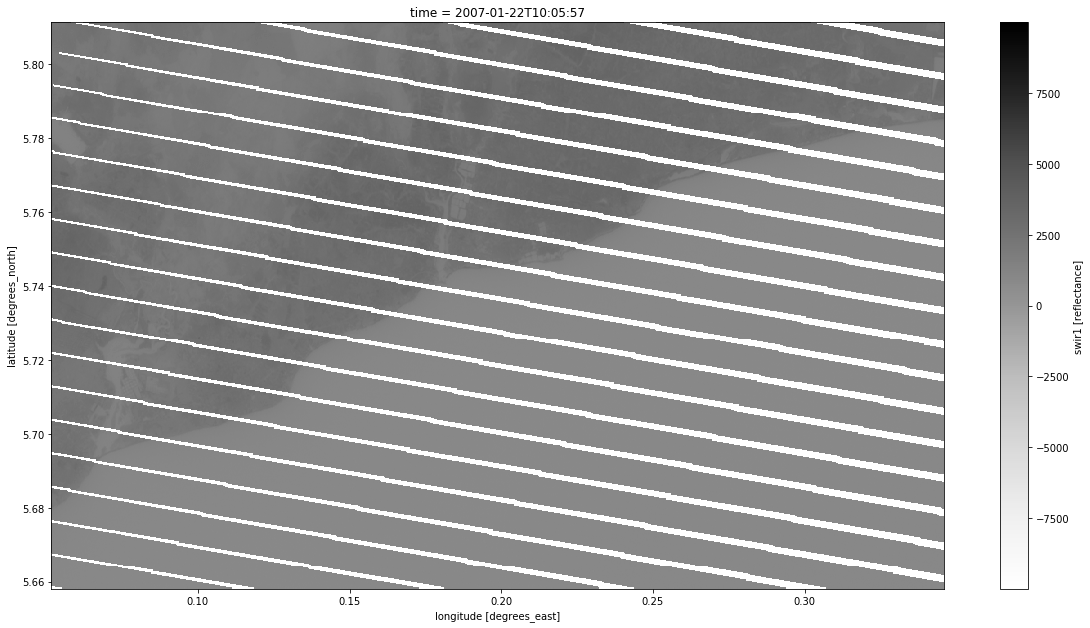

In [9]:
def figure_ratio(ds, fixed_width = 10):
    width = fixed_width
    height = len(ds.latitude) * (fixed_width / len(ds.longitude))
    return (width, height)

dataset.isel(time = 1).swir1.plot(cmap = "Greys", figsize = figure_ratio(dataset, fixed_width = 20))

The following code creates a composite that reduces all acquisitions in 2017, to a single cloud free statistical representation. 

In [10]:
import numpy as np  

def mask_water_and_land(dataset):    
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2 + 64
    water_pixels = dataset.pixel_qa.values == 4 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    return a_clean_mask


In [11]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

def mosaic(dataset):
    cloud_free_boolean_mask = mask_water_and_land(dataset)
    return create_median_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

In [12]:
composited_dataset = mosaic(dataset)

/home/localuser/miniconda3/envs/cubeenv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


**Visualize Composited imagery** 

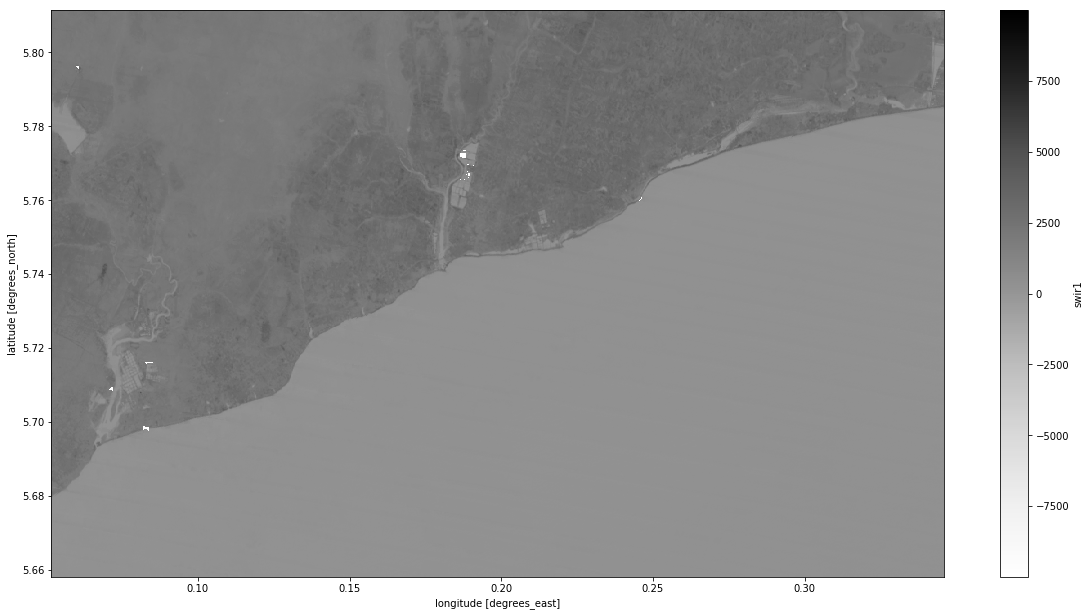

In [13]:
composited_dataset.swir1.plot(cmap = "Greys", figsize = figure_ratio(dataset, fixed_width = 20))

# water classification

In [14]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

water_classification = wofs_classify(composited_dataset, mosaic = True)

In [15]:
water_classification

<xarray.Dataset>
Dimensions:    (latitude: 569, longitude: 1092)
Coordinates:
  * latitude   (latitude) float64 5.811 5.811 5.811 5.81 ... 5.659 5.658 5.658
  * longitude  (longitude) float64 0.05188 0.05215 0.05242 ... 0.3456 0.3459
Data variables:
    wofs       (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0

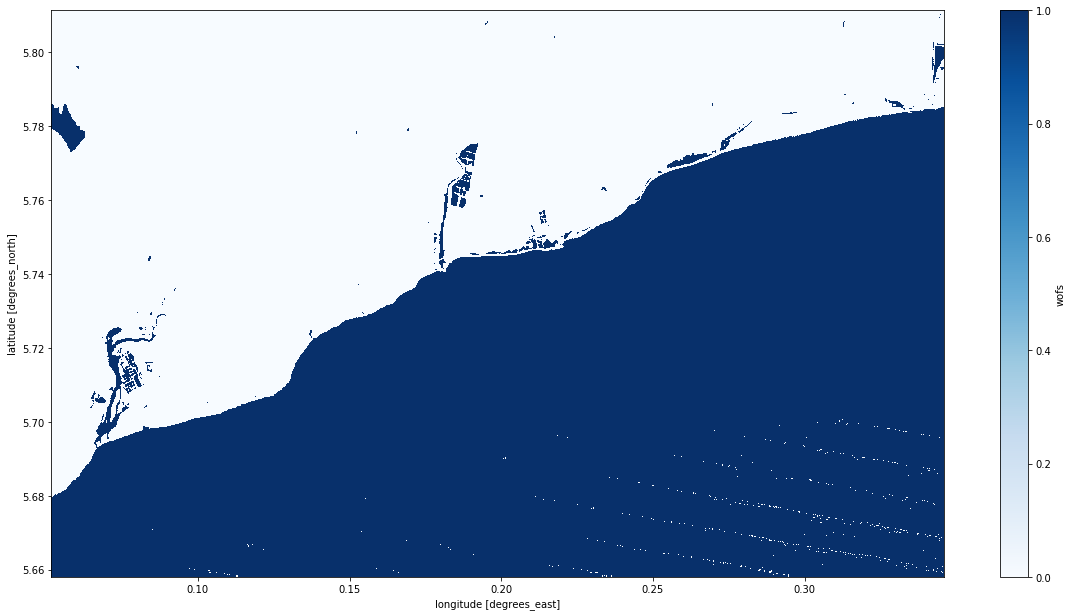

In [16]:
water_classification.wofs.plot(cmap = "Blues", figsize = figure_ratio(dataset, fixed_width = 20))

<br>

# run coastline classifier on water classification

In [17]:
coast = _coastline_classification(water_classification, water_band='wofs')

In [18]:
coast

<xarray.Dataset>
Dimensions:    (latitude: 569, longitude: 1092)
Coordinates:
  * latitude   (latitude) float64 5.811 5.811 5.811 5.81 ... 5.659 5.658 5.658
  * longitude  (longitude) float64 0.05188 0.05215 0.05242 ... 0.3456 0.3459
Data variables:
    coastline  (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0

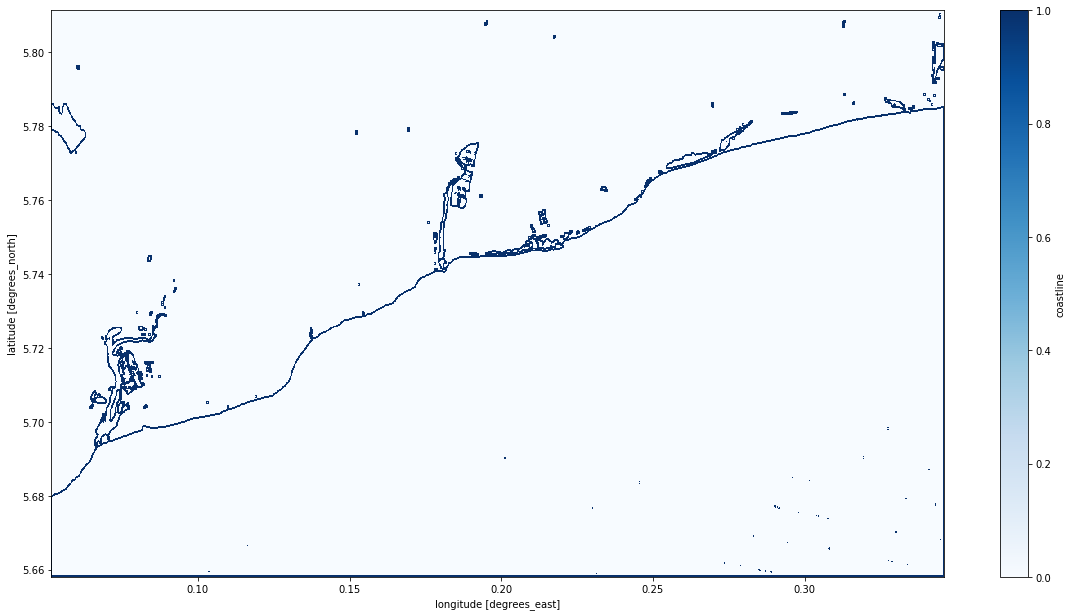

In [19]:
coast.coastline.plot(cmap = "Blues", figsize = figure_ratio(dataset, fixed_width = 20))